# Exercise X: Common Mistakes and Domain-Relevant Insights

This exercise is designed to help you identify and address common mistakes in machine learning workflows, with a specific focus on issues relevant to neuroscience data. You'll explore two key topics:

1. Cross-Validation and Avoiding Data Leakage
2. Handling Class Imbalance

## Part 1: [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html) and Avoiding [Data Leakage](https://www.kaggle.com/code/alexisbcook/data-leakage)

### **Introduction**
Cross-validation is a powerful technique to evaluate model performance by splitting the data into training and testing sets multiple times. However, improper handling of preprocessing steps can lead to **data leakage**, where information from the test set influences the training process, resulting in overly optimistic performance estimates.

### **Task 1: Identifying Data Leakage**

This exercise demonstrates the proper and improper ways to apply cross-validation in a classification task, focusing on feature selection. You’ll see how performing feature selection on the entire dataset before cross-validation ("the wrong way") can lead to misleadingly optimistic results, and how integrating feature selection within each cross-validation fold ("the correct way") provides a realistic error estimate.

### **Scenario**
- **Number of samples (N):** 50
- **Number of predictors (p):** 5000
- **Number of classes:** 2 (balanced)
- Predictors are **independent** of class labels (no real signal).
- **True error rate of any classifier:** 50%

We will:
1. Simulate the "wrong way": Feature selection on the entire dataset before cross-validation.
2. Simulate the "correct way": Feature selection within each cross-validation fold.

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np

# Generate synthetic data
N, p, num_predictors, K = 50, 5000, 100, 10
np.random.seed(0)
y = np.array([0] * (N // 2) + [1] * (N // 2))
np.random.shuffle(y)
X = np.random.randn(N, p)

n_simulations = 500

### **Step 1: Simulate the Wrong Way**

In [3]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier

def simulate_wrong(X:np.ndarray, y:np.ndarray, num_predictors:int, K:int) -> None:
    # Fit a KNN classifier with the wrong number of predictors
    selector_wrong = SelectKBest(score_func=f_classif, k=num_predictors)
    selector_wrong.fit(X, y)
    X_selected_wrong = selector_wrong.transform(X)

    # Initialize cross-validation
    kf = KFold(n_splits=K, shuffle=True, random_state=None)
    errors_wrong = []
    knn_wrong = KNeighborsClassifier(n_neighbors=1)

    for train_index, test_index in kf.split(X_selected_wrong):
        X_train, X_test = X_selected_wrong[train_index], X_selected_wrong[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the classifier
        knn_wrong.fit(X_train, y_train)

        # Predict on the test set
        y_pred = knn_wrong.predict(X_test)

        # Calculate error rate
        error = np.mean(y_pred != y_test)
        errors_wrong.append(error)

    avg_error_wrong = np.mean(errors_wrong)
    return avg_error_wrong

wrong_estimates = [simulate_wrong(X, y, num_predictors, K) for _ in range(n_simulations)]
print(
    f"Average error rate with the wrong number of predictors: {np.mean(wrong_estimates):.3f} ± {np.std(wrong_estimates):.3f}"
)

Average error rate with the wrong number of predictors: 0.044 ± 0.012


`````{admonition} Question:
* Why does feature selection on the entire dataset before cross-validation lead to an overly optimistic error rate?

````{dropdown} Solution
When feature selection is performed on the entire dataset before cross-validation, the test set indirectly influences the selection of features. This means that information from the test set leaks into the training process, leading to an overfit model that performs unrealistically well during validation. As a result, the estimated error rate is lower than the true error rate because the model has effectively "seen" part of the test data during training.
````
`````

### **Step 2: Simulate the Correct Way**

In [4]:
def simulate_right(X:np.ndarray, y:np.ndarray, num_predictors:int, K:int) -> None:
    # Initialize cross-validation
    errors_correct = []
    kf_correct = KFold(n_splits=K, shuffle=True, random_state=None)

    for train_index, test_index in kf_correct.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Feature selection on the training data only
        selector_correct = SelectKBest(score_func=f_classif, k=num_predictors)
        selector_correct.fit(X_train, y_train)
        X_train_selected = selector_correct.transform(X_train)
        X_test_selected = selector_correct.transform(X_test)

        # Train the classifier
        knn_correct = KNeighborsClassifier(n_neighbors=1)
        knn_correct.fit(X_train_selected, y_train)

        # Predict on the test set
        y_pred = knn_correct.predict(X_test_selected)

        # Calculate error rate
        error = np.mean(y_pred != y_test)
        errors_correct.append(error)

    avg_error_correct = np.mean(errors_correct)
    return avg_error_correct

right_estimates = [simulate_right(X, y, num_predictors, K) for _ in range(n_simulations)]
print(
    f"Average error rate with the right number of predictors: {np.mean(right_estimates):.3f} ± {np.std(right_estimates):.3f}"
)

Average error rate with the right number of predictors: 0.587 ± 0.056


### **Step 3: Compare Results**

True Error:   50.00%
Wrong Way:    4.37%
Correct Way:  58.75%
Conclusion:
The 'Wrong Way' of performing feature selection before cross-validation leads to an overly optimistic error rate.
The 'Correct Way' of integrating feature selection within each cross-validation fold provides an unbiased estimate of the true error rate.


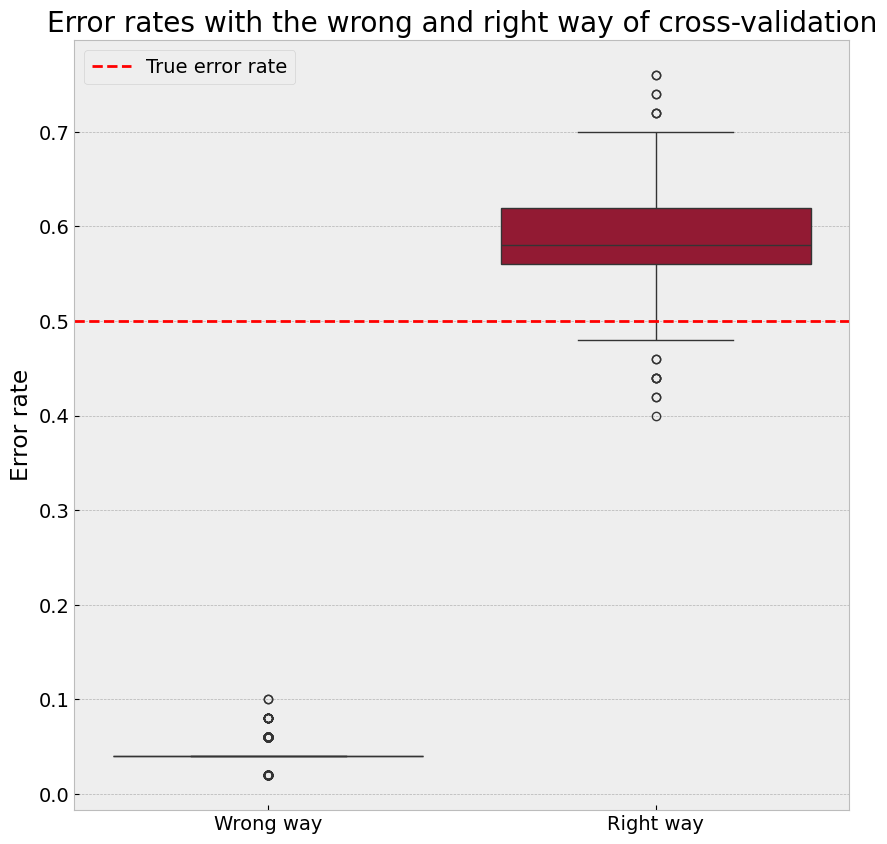

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams.update({'font.size': 14})

true_error = 50.0  # True error rate (no signal in data)
avg_error_wrong = np.mean(wrong_estimates)
avg_error_correct = np.mean(right_estimates)
print("========================================")
print(f"True Error:   {true_error:.2f}%")
print(f"Wrong Way:    {avg_error_wrong * 100:.2f}%")
print(f"Correct Way:  {avg_error_correct * 100:.2f}%")
print("========================================")

print("Conclusion:")
print("The 'Wrong Way' of performing feature selection before cross-validation leads to an overly optimistic error rate.")
print("The 'Correct Way' of integrating feature selection within each cross-validation fold provides an unbiased estimate of the true error rate.")

# plot the distribution of error rates and the true error rate
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(data=[wrong_estimates, right_estimates], ax=ax)
# add a horizontal line for the true error rate
ax.axhline(0.5, color='red', linestyle='--', label='True error rate')
ax.set_xticklabels(["Wrong way", "Right way"])
ax.set_ylabel("Error rate")
ax.set_title("Error rates with the wrong and right way of cross-validation")
plt.legend()
plt.show()


`````{admonition} Question:
* How does performing feature selection within each fold of cross-validation provide a more accurate error estimate?

````{dropdown} Solution
Performing feature selection within each fold ensures that the test set remains completely unseen during the training process. This avoids data leakage, as the feature selection is based solely on the training data within that fold. By doing this, the evaluation provides a realistic estimate of the model's performance on truly unseen data, preventing over-optimistic error rates.

````
`````

## Additional Notes
### The 'Correct Way' often produces error rates higher than the true error rate (e.g., ~60%) in this scenario. This happens because:
1. The predictors are randomly generated and independent of the labels, so selected features correlate with the labels purely by chance.
2. High dimensionality and small sample size lead to overfitting, especially with inconsistent feature sets across folds.
3. The nearest-neighbor classifier is sensitive to noisy or irrelevant features, highlighting this issue.

## To further investigate:
* Inspect the features selected in each fold.
* Reduce the number of predictors (e.g., from 5000 to 500) and observe the results.
* Use a different classifier (e.g., logistic regression) to reduce sensitivity to noise.

### **Other Sources of Data Leakage**
Feature selection is just one example of data leakage. Other preprocessing steps can also inadvertently introduce leakage if applied to the entire dataset before splitting into training and testing sets. Examples include:

- **Normalization or Standardization:** Scaling features based on the entire dataset rather than only on the training set can allow information from the test set to influence the training process.
- **Dimensionality Reduction:** Methods like PCA, when applied before splitting the data, use information from the test set to define components, leading to over-optimistic evaluations.
- **Target Encoding for Categorical Variables:** If encoding schemes that depend on the target variable are applied globally, the test set's target values influence the training process.
- **Imputation of Missing Data:** Imputing missing values using statistics (e.g., mean, median) computed over the entire dataset can leak test set information into the training set.

### **Summary of Data Leakage**
Data leakage occurs whenever information from the test set influences the training process. It leads to overly optimistic error estimates and unreliable models. To avoid data leakage:
- Perform all preprocessing steps (e.g., scaling, feature selection, dimensionality reduction) separately within each fold of cross-validation.
- Treat the test set as truly unseen data, ensuring no information flows from the test set to the training process.

---


## Part 2: [Handling Imbalanced Data](https://machinelearningmastery.com/what-is-imbalanced-classification/)

### **Introduction**
Class imbalance is a common issue in machine learning, where one class significantly outnumbers the other(s). This can result in biased models that favor the majority class, leading to poor performance on the minority class, which may be the class of interest.

In this part of the tutorial, you will:

1. Observe the effects of class imbalance on model performance.
2. Apply techniques like class weighting and SMOTE (Synthetic Minority Oversampling Technique) to address imbalance.
3. Evaluate and compare the improvements in model performance.

### **Step 1: Loading an [Imbalanced Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)**

![image](creditcard_fraud_detection.png)

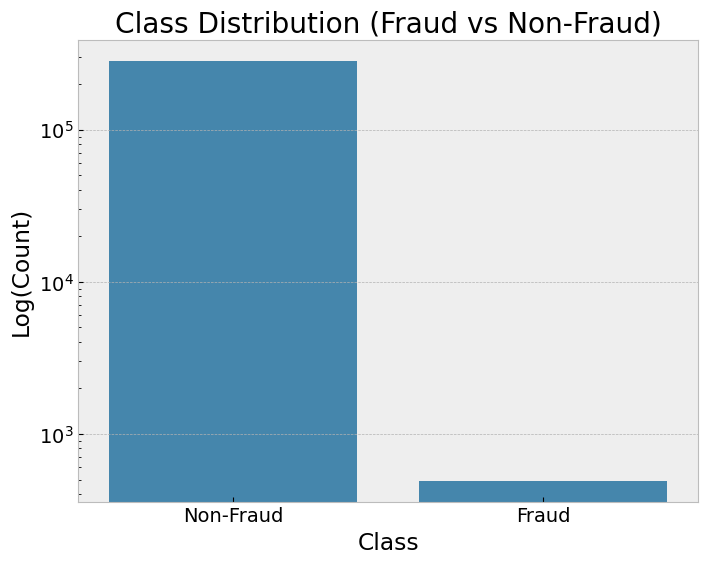

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("creditcard.csv")

# Display class distribution
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x="Class", data=df, ax=ax)
ax.set_title("Class Distribution (Fraud vs Non-Fraud)")
ax.set_yscale("log")
ax.set_ylabel("Log(Count)")
ax.set_xticklabels(["Non-Fraud", "Fraud"])
plt.show()

# Split the dataset into features and target
X = df.drop(columns=["Class"])
y = df["Class"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

### **Step 2: Training Logistic Regression on Imbalanced Data**

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train a logistic regression model
model_imbalanced = LogisticRegression(solver="liblinear", random_state=42)
model_imbalanced.fit(X_train, y_train)

# Predict
y_pred_imbalanced = model_imbalanced.predict(X_test)

### **Step 3: Using [Class Weighting](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/) to Handle Imbalance**

In [8]:
# Train a logistic regression model with class weighting
model_weighted = LogisticRegression(
    solver="liblinear", class_weight="balanced", random_state=42
)
model_weighted.fit(X_train, y_train)

# Predict
y_pred_weighted = model_weighted.predict(X_test)

### Step 4: Oversampling with SMOTE and Other Sampling Techniques**
#### **Descriptions of Sampling Methods**
- **[SMOTE (Synthetic Minority Oversampling Technique)](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html):** Generates synthetic samples for the minority class by interpolating between existing minority class samples.
- **[Random Oversampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html):** Duplicates minority class samples randomly to balance the dataset.
- **[Random Undersampling](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html):** Reduces the majority class size by randomly removing samples to balance the dataset.


In [9]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Train logistic regression models
model_smote = LogisticRegression(solver="liblinear", random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

model_ros = LogisticRegression(solver="liblinear", random_state=42)
model_ros.fit(X_train_ros, y_train_ros)

model_rus = LogisticRegression(solver="liblinear", random_state=42)
model_rus.fit(X_train_rus, y_train_rus)

# Predict with SMOTE
y_pred_smote = model_smote.predict(X_test)

# Predict with Random Oversampling
y_pred_ros = model_ros.predict(X_test)

# Predict with Random Undersampling
y_pred_rus = model_rus.predict(X_test)

### **Step 5: Comparing Results**

#### **Choosing Metrics for Comparison**
- **ROC-AUC ([Receiver Operating Characteristic](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) - Area Under Curve):**
  Measures the model’s ability to distinguish between classes across various thresholds. A higher AUC indicates better discrimination.
  - Useful for evaluating overall model performance when false positives and false negatives are equally important.

- **PR-AUC ([Precision-Recall](https://scikit-learn.org/1.5/auto_examples/model_selection/plot_precision_recall.html) AUC):**
  Focuses on the precision-recall tradeoff, particularly valuable for imbalanced datasets. PR-AUC highlights the model’s performance in predicting the minority class.
  - More informative than ROC-AUC when the positive class is rare.

- **[F1-Score](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.f1_score.html):**
  Balances precision and recall, making it suitable for cases where the cost of false positives and false negatives are significant.
  - Provides a single score to gauge model performance when class distributions are uneven.

By comparing these metrics, you gain a comprehensive understanding of model performance for both majority and minority classes, ensuring the chosen model aligns with your use case.


In [10]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc


# Function to plot ROC curves
def plot_roc_curves(y_test:np.ndarray, models:np.ndarray, labels:np.ndarray, ax:np.ndarray) -> None:
    """
    Plot ROC curves for multiple models.

    Parameters
    ----------
    y_test : np.array
        True labels
    models : fitted models
        List of fitted models
    labels : list
        List of model names
    ax : matplotlib axes
        Axes to plot the ROC curves
    """
    for model, label in zip(models, labels):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        ax.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

    # Plot diagonal line
    ax.plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC-AUC Comparison")
    ax.legend(loc="lower right")

# function to plot PR curves
def plot_pr_curves(y_test:np.ndarray, models:np.ndarray, labels:np.ndarray, ax:np.ndarray) -> None:
    """
    Plot precision-recall curves for multiple models.

    Parameters
    ----------
    y_test : np.array
        True labels
    models : fitted models
        List of fitted models
    labels : list
        List of model names
    ax : matplotlib axes
        Axes to plot the PR curves
    """
    for model, label in zip(models, labels):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        ax.plot(recall, precision, label=f"{label} (AUC = {pr_auc:.2f})")

    # set horizontal line for the baseline
    ax.axhline(y=sum(y_test) / len(y_test), color="navy", linestyle="--")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision-Recall Comparison")
    ax.legend(loc="lower left")

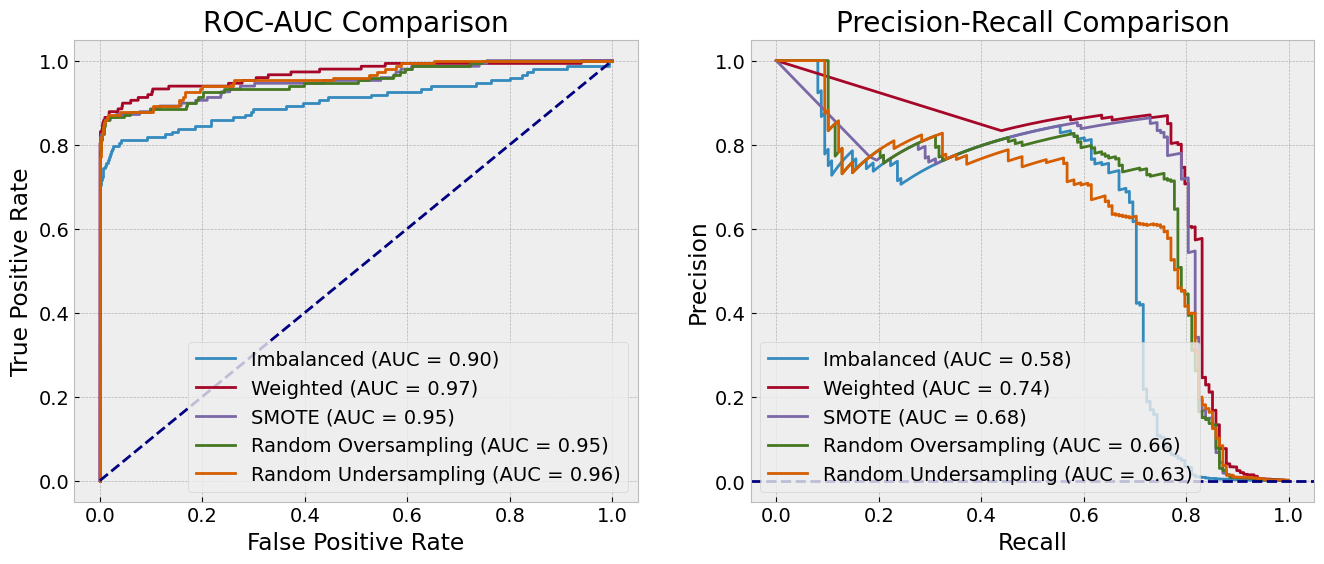

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_roc_curves(y_test, [model_imbalanced, model_weighted, model_smote, model_ros, model_rus],
                ["Imbalanced", "Weighted", "SMOTE", "Random Oversampling", "Random Undersampling"], axes[0])
plot_pr_curves(y_test, [model_imbalanced, model_weighted, model_smote, model_ros, model_rus],
                ["Imbalanced", "Weighted", "SMOTE", "Random Oversampling", "Random Undersampling"], axes[1])


              Technique  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0            Imbalanced   0.738462  0.648649  0.690647  0.903861  0.581640
1       Class Weighting   0.066872  0.878378  0.124283  0.967929  0.702332
2                 SMOTE   0.080278  0.858108  0.146821  0.952065  0.662726
3   Random Oversampling   0.055411  0.864865  0.104150  0.950780  0.658294
4  Random Undersampling   0.051231  0.871622  0.096774  0.959640  0.628496


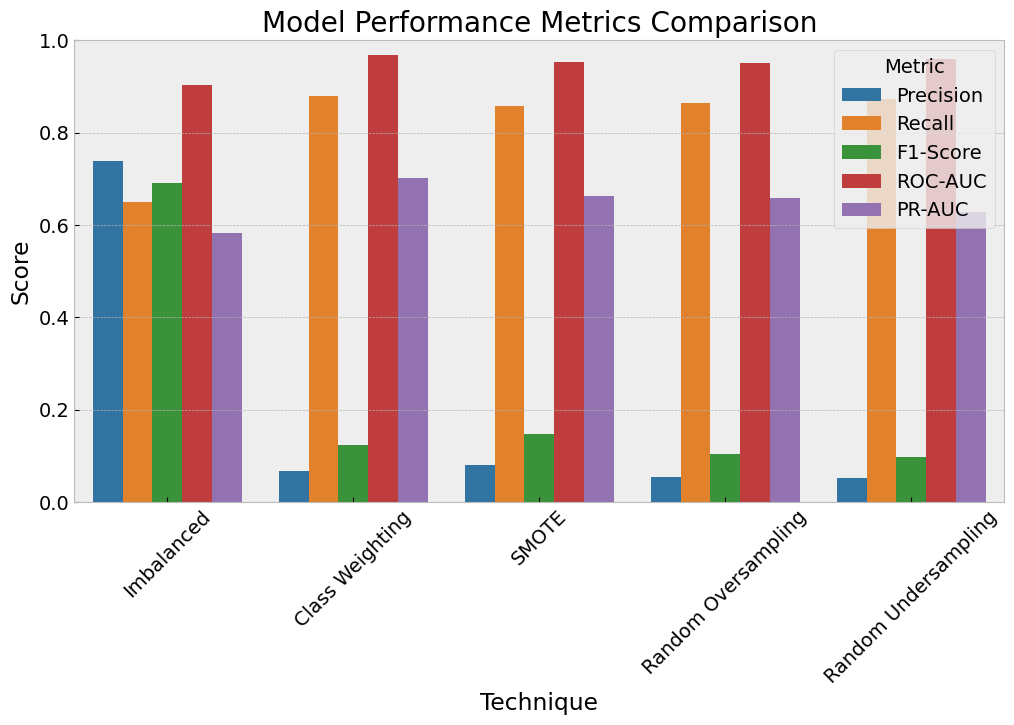

In [12]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
)

metrics = {
    "Technique": [
        "Imbalanced",
        "Class Weighting",
        "SMOTE",
        "Random Oversampling",
        "Random Undersampling",
    ],
    "Precision": [
        precision_score(y_test, y_pred_imbalanced, zero_division=0),
        precision_score(y_test, y_pred_weighted, zero_division=0),
        precision_score(y_test, y_pred_smote, zero_division=0),
        precision_score(y_test, y_pred_ros, zero_division=0),
        precision_score(y_test, y_pred_rus, zero_division=0),
    ],
    "Recall": [
        recall_score(y_test, y_pred_imbalanced),
        recall_score(y_test, y_pred_weighted),
        recall_score(y_test, y_pred_smote),
        recall_score(y_test, y_pred_ros),
        recall_score(y_test, y_pred_rus),
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_imbalanced, zero_division=0),
        f1_score(y_test, y_pred_weighted, zero_division=0),
        f1_score(y_test, y_pred_smote, zero_division=0),
        f1_score(y_test, y_pred_ros, zero_division=0),
        f1_score(y_test, y_pred_rus, zero_division=0),
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, model_imbalanced.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, model_weighted.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, model_smote.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, model_ros.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, model_rus.predict_proba(X_test)[:, 1]),
    ],
    "PR-AUC": [
        average_precision_score(y_test, model_imbalanced.predict_proba(X_test)[:, 1]),
        average_precision_score(y_test, model_weighted.predict_proba(X_test)[:, 1]),
        average_precision_score(y_test, model_smote.predict_proba(X_test)[:, 1]),
        average_precision_score(y_test, model_ros.predict_proba(X_test)[:, 1]),
        average_precision_score(y_test, model_rus.predict_proba(X_test)[:, 1]),
    ],
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Visualize metrics
melted_metrics = pd.melt(
    metrics_df, ["Technique"], var_name="Metric", value_name="Score"
)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="Technique", y="Score", hue="Metric", data=melted_metrics, palette="tab10", ax=ax
)
ax.set_title("Model Performance Metrics Comparison")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.legend(title="Metric")
plt.xticks(rotation=45)
plt.show()

### **Wrap-Up**

- There are many techniques for handling imbalanced data, and the choice of method depends on the problem and dataset characteristics.
- An important question to ask is: **How do we define a "good" model?** The definition of "good" depends on the specific application and the costs of false positives and false negatives.
  - **Example:** In a medical diagnosis context, recall (sensitivity) might be prioritized to ensure all potential cases are identified, even at the cost of false positives.
  - **Example:** In fraud detection, precision might be more critical to avoid flagging legitimate transactions.

#### **Rules of Thumb**
1. Use **PR-AUC** over **ROC-AUC** when the dataset is highly imbalanced, as PR-AUC focuses more on the minority class.
2. Evaluate multiple metrics (e.g., F1-Score, ROC-AUC, PR-AUC) to get a comprehensive view of model performance.
3. Test different techniques (e.g., SMOTE, class weighting, undersampling) and assess their impact on both minority and majority class performance.